## Przykłady wykorzystania modułów


### Importy

Tutaj są wszystkie koniecze importy, ale pod instalację jest plik requirements.txt w głównym folderze projektu


In [ ]:
from skimage.morphology import skeletonize
from graph_remaker.morphological_remaker import discover_streets

### Training target model


#### Downloading cities


In [ ]:
import random
from scraper.data_loader import DataLoader
from trainer.model import Model
from trainer.trainer import Trainer


# List of Polish cities with population between 50,000 and 500,000
cities = [
    # ("Warsaw", 1790658),
    # ("Kraków", 780981),
    # ("Łódź", 687702),
    # ("Wrocław", 640648),
    # ("Poznań", 538633),
    ("Gdańsk", 466630),
    ("Szczecin", 402465),
    ("Bydgoszcz", 358928),
    ("Lublin", 339433),
    ("Białystok", 297459),
    ("Katowice", 294510),
    ("Gdynia", 246635),
    ("Częstochowa", 224000),
    ("Radom", 214000),
    ("Toruń", 202074),
    ("Kielce", 200000),
    ("Rzeszów", 196000),
    ("Opole", 128000),
    ("Gliwice", 180000),
    ("Zabrze", 170000),
    ("Elbląg", 120000),
    ("Płock", 120000),
    ("Nowy Sącz", 85_000),
    ("Słupsk", 91_000),
    ("Świętochłowice", 55_000),
    ("Jelenia Góra", 79_000),
    ("Stalowa Wola", 75_000),
    ("Koszalin", 108_000),
    ("Mielec", 59_000),
    ("Legnica", 100_000),
    ("Tychy", 130_000),
    ("Chorzów", 110_000),
    ("Rybnik", 140_000)
]

# Randomly select 8 cities
random_cities = random.sample(cities, 8)

loader = DataLoader(1, 2000, 2000)
managers = []
files = []

for city, population in random_cities:
    file_name = city + ".city_grid"
    manager = loader.load_city_grid(city, file_name)
    files.append(file_name)
    managers.append(manager)
    loader.add_elevation_to_grid(manager)

### Download mesh and get grid from OSM


In [ ]:
from scraper.data_loader import DataLoader
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [ ]:
# IMPORTANT!! - dataloader checks, if the file already exists
from scraper.data_loader import DataLoader

cityname = "Kraków"

loader = DataLoader(1)

grid_manager = loader.load_city_grid(cityname, cityname + ".dat")
# loader.add_elevation_to_grid(grid_manager)
loader.add_residential_to_grid(grid_manager)

In [ ]:
from grid_manager import GridManager

grid_manager = GridManager("Tychy.dat")
img = grid_manager.read_segment(2,0)[:5000, :5000, 0]

struct_el = np.ones((3,3))
dilated = cv2.dilate(img, struct_el, iterations=3)
plt.gray()
plt.imshow(dilated)

In [ ]:
from grid_manager import GridManager
from scraper.rasterizer import Rasterizer 
import matplotlib.pyplot as plt
import math

grid_manager = GridManager("Kraków.dat")
meta = grid_manager.get_metadata()
segments_rows = math.ceil(meta.rows_number / meta.segment_h)
segments_cols = math.ceil(meta.columns_number / meta.segment_w)


rasterizer = Rasterizer()
fig, axes = plt.subplots(segments_rows, segments_cols)
fig.set_size_inches((16, 16))
axes = axes.flatten()
axes_index = 0

for row_idx in range(segments_rows):
    for col_idx in range(segments_cols):
        segment = grid_manager.read_segment(row_idx, col_idx)

        axes[axes_index].imshow(segment[:, :, 2], cmap="gray")
        axes[axes_index].set_title(f"Segment_rows: {row_idx}, segment_cols: {col_idx}")
        axes_index += 1

In [ ]:
from grid_manager import GridManager

grid_manager = GridManager("Tychy.dat")
img = grid_manager.read_segment(1,1)[:2000, :2000, 0]

fig, axs = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle("Obrazki dróg (zdylatowane, żeby było lepiej widać)")

imgs = [
    [grid_manager.read_segment(0,0)[3000:, 3000:, 0], grid_manager.read_segment(0,1)[3000:, :2000, 0]],
    [grid_manager.read_segment(1,0)[:2000, 3000:, 0], grid_manager.read_segment(1,1)[:2000, :2000, 0]]
]

dilated_imgs = []

struct_el = np.ones((3,3))

for imgs_row in imgs:
    target_row = []
    dilated_imgs.append(target_row)
    for img in imgs_row:
        target_row.append(cv2.dilate(img, struct_el, iterations=3))

plt.gray()
axs[0,0].imshow(dilated_imgs[0][0])
axs[0,1].imshow(dilated_imgs[0][1])
axs[1,0].imshow(dilated_imgs[1][0])
axs[1,1].imshow(dilated_imgs[1][1])

In [ ]:
from scraper.grid_builder import GridBuilder
import math
from scraper.rasterizer import Rasterizer
import matplotlib.pyplot as plt

city = "Tychy, Polska"
builder = GridBuilder()

gdf_edges = builder.get_city_roads(city)

rasterizer = Rasterizer()

grid_2d = rasterizer.get_rasterize_roads(gdf_edges, 1, is_residential=False)
plt.imshow(grid_2d, cmap="gray")
plt.title(f"City: {city}")

In [ ]:
from scraper.grid_builder import GridBuilder
import math
from scraper.rasterizer import Rasterizer
import matplotlib.pyplot as plt
import geopandas as gpd

city = "Kraków"
builder = GridBuilder()
grid_density = 1
segment_h = 5000
segment_w = 5000
data_dir = "grids"

gdf_edges = builder.get_city_roads(city)
min_x, min_y, max_x, max_y = gdf_edges.total_bounds

columns_number = math.ceil((max_x - min_x) / grid_density)
rows_number = math.ceil((max_y - min_y) / grid_density)

segment_rows = math.ceil((rows_number) / segment_h)
segment_cols = math.ceil((columns_number) / segment_h)

# grid_manager = GridManager(file_name, rows_number=int(rows_number), columns_number=int(columns_number),
#                             grid_density=grid_density, segment_h=segment_h, segment_w=segment_w,
#                             data_dir=data_dir, upper_left_longitude=min_x, upper_left_latitude=max_y)
print(f"Height: {int(rows_number)}, Width: {int(columns_number)}, rows: {segment_rows}, cols: {segment_cols}")

rasterizer = Rasterizer()
fig, axes = plt.subplots(segment_rows, segment_cols)
fig.set_size_inches((16, 16))
axes = axes.flatten()
axes_index = 0
# single_row_gdf = gdf_edges.sample(1)

# grid_2d = rasterizer.rasterize_segment_from_indexes(gdf_edges=single_row_gdf, indexes=(0, 0), is_residential=False
#                                                             size_h=segment_h, size_w=segment_w,
#                                                             pixel_size=grid_density)
# print(grid_2d.shape)
# plt.imshow(grid_2d, cmap="gray")

for i in range(segment_rows):
    for j in range(segment_cols):
        grid_2d = rasterizer.rasterize_segment_from_indexes(gdf_edges=gdf_edges, indexes=(i, j), is_residential=False,
                                                            size_h=segment_h, size_w=segment_w,
                                                            pixel_size=grid_density)
        axes[axes_index].imshow(grid_2d, cmap="gray")
        axes[axes_index].set_title(f"Segment_rows: {i}, segment_cols: {j}")
        axes_index += 1

### Data management


In [ ]:
from grid_manager import GridManager
import numpy as np

filename = "przyklad1.dat"

src_man = GridManager(filename, 2000, 2000, 0.0, 0.0, 1, 3, 3)

# a = np.zeros((2000, 2000, 2), dtype=np.float64)
is_street = np.array([
    [1, 2, 3, 4, 5, 6],
    [11, 12, 13, 14, 15, 16],
    [21, 22, 23, 24, 25, 26],
    [31, 32, 33, 34, 35, 36],
    [41, 42, 43, 44, 45, 46],
    [51, 52, 53, 54, 55, 56],
])
a = np.zeros((is_street.shape[0], is_street.shape[1], 3))
a[:,:, 0] = is_street

for x in range(2):
    for y in range(2):
        src_man.write_segment(a[y * 3: (y + 1) * 3, x*3:(x + 1) * 3], y, x)


src_man.write_segment(a[:2,:3, :] + 1, 666, 0)
src_man.write_segment(a[:3,:2, :] + 2, 0, 666)

man = src_man.deep_copy()

print(f"1: {man.read_segment(0, 0)[:, :, 0]}")
print(f"2: {man.read_segment(0, 1)[:, :, 0]}")
print(f"3: {man.read_segment(1, 0)[:, :, 0]}")
print(f"4: {man.read_segment(1, 1)[:, :, 0]}")
print(f"5: {man.read_segment(666, 666)[:, :, 0]}")

print(man.get_metadata())

man.delete()


### Streets discovery


In [ ]:
import matplotlib.pyplot as plt

def show_crossroads(img_height, img_width, conflictless_crossroads, conflicting_crossroads):
    fig, axs = plt.subplots(  max(2, len(conflictless_crossroads), len(conflicting_crossroads)), 6, figsize=(10,5))
    axs[0, 0].set_title("conflictless")
    axs[0, 1].set_title("junctions")
    axs[0, 2].set_title("conflicts")
    axs[0, 3].set_title("conflicting")
    axs[0, 4].set_title("junctions")
    axs[0, 5].set_title("conflicts")


    for i in range(len(conflictless_crossroads)):
        crossroad = conflictless_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for point in crossroad.points:
            crossroad_image[point] = 1

        axs[i, 0].imshow(crossroad_image)

    for i in range(len(conflictless_crossroads)):
        crossroad = conflictless_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for street in crossroad.street_junctions.keys():
            crossroad_image[crossroad.street_junctions[street]] = 1

        axs[i, 1].imshow(crossroad_image)

    for i in range(len(conflictless_crossroads)):
        crossroad = conflictless_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for point in crossroad.conflicting_points:
            crossroad_image[point] = 1

        axs[i, 2].imshow(crossroad_image)

    for i in range(len(conflicting_crossroads)):
        crossroad = conflicting_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for point in crossroad.points:
            crossroad_image[point] = 1

        axs[i, 3].imshow(crossroad_image)

    for i in range(len(conflicting_crossroads)):
        crossroad = conflicting_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for street in crossroad.street_junctions.keys():
            crossroad_image[crossroad.street_junctions[street]] = 1

        axs[i, 4].imshow(crossroad_image)

    for i in range(len(conflicting_crossroads)):
        crossroad = conflicting_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for point in crossroad.conflicting_points:
            crossroad_image[point] = 1

        axs[i, 5].imshow(crossroad_image)


In [ ]:
import matplotlib.pyplot as plt

def show_streets(img_height, img_width, conflictless_streets, conflicting_streets):
    fig, axs = plt.subplots(  max(2, len(conflictless_streets), len(conflicting_streets)), 4, figsize=(10,8))
    axs[0, 0].set_title("conflictless")
    axs[0, 1].set_title("conflicts")
    axs[0, 2].set_title("conflicting")
    axs[0, 3].set_title("conflicts")


    for i in range(len(conflictless_streets)):
        street = conflictless_streets[i]

        street_image = np.zeros((img_height, img_width))
        for point in street.linestring:
            street_image[point] = 1

        axs[i, 0].imshow(street_image)
    
    for i in range(len(conflictless_streets)):
        street = conflictless_streets[i]

        street_image = np.zeros((img_height, img_width))
        for point in street.conflicts:
            street_image[point] = 1

        axs[i, 1].imshow(street_image)

    for i in range(len(conflicting_streets)):
        street = conflicting_streets[i]

        street_image = np.zeros((img_height, img_width))
        for point in street.linestring:
            street_image[point] = 1

        axs[i, 2].imshow(street_image)
    
    for i in range(len(conflicting_streets)):
        street = conflicting_streets[i]

        street_image = np.zeros((img_height, img_width))
        for point in street.conflicts:
            street_image[point] = 1

        axs[i, 3].imshow(street_image)


#### Diamond


In [ ]:
import numpy as np
from skimage.morphology import skeletonize
from graph_remaker.morphological_remaker import discover_streets
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("test_images/diamond.png", cv2.IMREAD_GRAYSCALE)
plt.gray()
bin_image = image > 0
# plt.imshow(bin_image * 255)

processed_image = bin_image[:, :, np.newaxis]
processed_image = np.concatenate((processed_image, np.zeros(processed_image.shape)), axis=2)

conflictless_crossroads, conflicting_crossroads, conflictless_streets, conflicting_streets = discover_streets(processed_image)

height, width = image.shape
plt.imshow(image)

In [ ]:
show_crossroads(height, width, conflictless_crossroads, conflicting_crossroads)

In [ ]:
show_streets(height, width, conflictless_streets, conflicting_streets)

#### Conflicting crossroad and dead-end


In [ ]:
import numpy as np
from skimage.morphology import skeletonize
from graph_remaker.morphological_remaker import discover_streets
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("test_images/crossroad_conflict_deadend.png", cv2.IMREAD_GRAYSCALE)
plt.gray()
bin_image = image > 0
# plt.imshow(bin_image * 255)

processed_image = bin_image[:, :, np.newaxis]
processed_image = np.concatenate((processed_image, np.zeros(processed_image.shape)), axis=2)

conflictless_crossroads, conflicting_crossroads, conflictless_streets, conflicting_streets = discover_streets(processed_image)

height, width = image.shape
plt.imshow(image)

In [ ]:
show_crossroads(width, height, conflictless_crossroads, conflicting_crossroads)

In [ ]:
show_streets(width, height, conflictless_streets, conflicting_streets)

# Model training


In [1]:
from trainer.clipping_sequence import ClippingBatchSequence
from trainer.batch_sequence import BatchSequence

2026-01-15 11:57:06.223764: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-15 11:57:06.478389: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-15 11:57:07.913433: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/jakseluz/miniconda3/envs/croada/lib/python3.12/site-packages/keras/src/exp

#### Create batch sequence of clippings that are the candidates for a model and print the shape of the input


In [2]:
batchSeq = ClippingBatchSequence(
            BatchSequence(
                files=list(["Tychy.dat"]),
                batch_size=1,
                cut_sizes=[(512, 512)],
            ),
            clipping_size=512,
            input_grid_surplus=64,
        )

X, Y = batchSeq[0]
print(X.shape)

Cut size: (512, 512), Max start points: x=11190, y=9956
Requested cut at (5301, 1321) of size (512, 512) with surplus 0, clipping=False
Cut from segments: start_x=5301, start_y=1321, end_x=5813, end_y=1833
Segment size: w=5000, h=5000
Segments to read: start_x=1, start_y=0, end_x=1, end_y=0
Reading segment at (1, 0) with shape (5000, 5000, 3)
Clipping index: 0 -> 0 0
Requested cut at (0, 0) of size (512, 512) with surplus 64, clipping=True
Cut from segments: start_x=0, start_y=0, end_x=512, end_y=512
Segment size: w=5000, h=5000
Segments to read: start_x=0, start_y=0, end_x=0, end_y=0
Reading segment at (0, 0) with shape (512, 512, 3)
Batch shapes so far: (1, 512, 512, 2) (1, 2, 448, 448, 1)
(1, 512, 512, 2)


#### Display example clipping (X and y)


X min/max: 0.0 1.0
Y min/max: 0.0 1.0


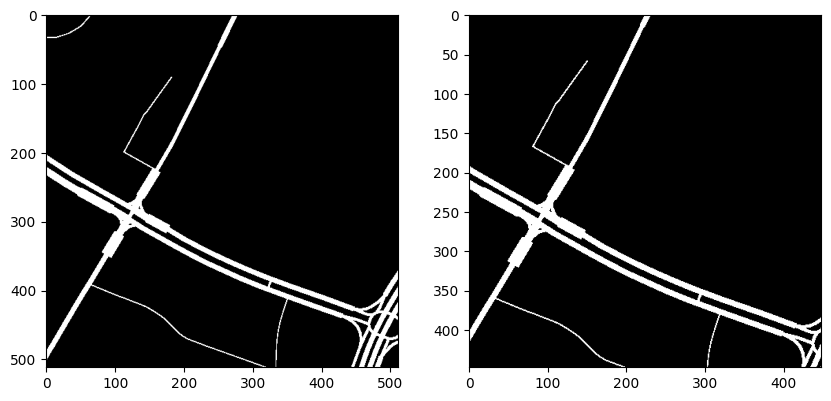

In [3]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(X[0, :, :, 0], cmap='grey')
axs[1].imshow(Y["is_street"][0, :, :, 0], cmap='grey')
print("X min/max:", X[0, :, :, 0].min(), X[0, :, :, 0].max())
print("Y min/max:", Y["is_street"][0, :, :, 0].min(), Y["is_street"][0, :, :, 0].max())

#### Show available GPUs


In [4]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


I0000 00:00:1768474640.104385   88788 gpu_device.cc:2020] Created device /device:GPU:0 with 2136 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


#### Define a model and then cities for the trainer (e.g. Tychy) as the files list


In [5]:
from trainer.clipping_model import ClippingModel, tf
from trainer.trainer import Trainer

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

model = ClippingModel(clipping_size=512, clipping_surplus=64, path="model_test_13_01_13_22")
trainer = Trainer(model=model, files=["Tychy.dat", "Kraków.dat"])

Num GPUs Available:  1


I0000 00:00:1768474642.716765   88788 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2136 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


#### Run fitting which created the above batch sequence and trains the model

`random_fit_from_files(self, epochs: int = 100, steps_per_epoch=1000)`


In [6]:
trainer.random_fit_from_files(1, 10)

Requested cut at (22129, 5551) of size (512, 512) with surplus 0, clipping=False
Cut from segments: start_x=22129, start_y=5551, end_x=22641, end_y=6063
Segment size: w=5000, h=5000
Segments to read: start_x=4, start_y=1, end_x=4, end_y=1
Reading segment at (4, 1) with shape (5000, 5000, 3)
Requested cut at (0, 0) of size (512, 512) with surplus 64, clipping=True
Cut from segments: start_x=0, start_y=0, end_x=512, end_y=512
Segment size: w=5000, h=5000
Segments to read: start_x=0, start_y=0, end_x=0, end_y=0
Reading segment at (0, 0) with shape (512, 512, 3)
Requested cut at (16232, 15685) of size (512, 512) with surplus 0, clipping=False
Cut from segments: start_x=16232, start_y=15685, end_x=16744, end_y=16197
Segment size: w=5000, h=5000
Segments to read: start_x=3, start_y=3, end_x=3, end_y=3
Reading segment at (3, 3) with shape (2018, 5000, 3)
Requested cut at (0, 0) of size (512, 512) with surplus 64, clipping=True
Cut from segments: start_x=0, start_y=0, end_x=512, end_y=512
Segm

2026-01-15 11:57:33.560176: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f56b8002d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-15 11:57:33.560194: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2026-01-15 11:57:33.621738: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


Reading segment at (1, 3) with shape (2018, 5000, 3)
Requested cut at (0, 0) of size (512, 512) with surplus 64, clipping=True
Cut from segments: start_x=0, start_y=0, end_x=512, end_y=512
Segment size: w=5000, h=5000
Segments to read: start_x=0, start_y=0, end_x=0, end_y=0
Reading segment at (0, 0) with shape (512, 512, 3)
Requested cut at (23737, 3428) of size (512, 512) with surplus 0, clipping=False
Cut from segments: start_x=23737, start_y=3428, end_x=24249, end_y=3940
Segment size: w=5000, h=5000
Segments to read: start_x=4, start_y=0, end_x=4, end_y=0


2026-01-15 11:57:34.066326: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701


Reading segment at (4, 0) with shape (5000, 5000, 3)
Requested cut at (0, 0) of size (512, 512) with surplus 64, clipping=True
Cut from segments: start_x=0, start_y=0, end_x=512, end_y=512
Segment size: w=5000, h=5000
Segments to read: start_x=0, start_y=0, end_x=0, end_y=0
Reading segment at (0, 0) with shape (512, 512, 3)
Requested cut at (27353, 6229) of size (512, 512) with surplus 0, clipping=False
Cut from segments: start_x=27353, start_y=6229, end_x=27865, end_y=6741
Segment size: w=5000, h=5000
Segments to read: start_x=5, start_y=1, end_x=5, end_y=1
Reading segment at (5, 1) with shape (5000, 4683, 3)
Requested cut at (0, 0) of size (512, 512) with surplus 64, clipping=True
Cut from segments: start_x=0, start_y=0, end_x=512, end_y=512
Segment size: w=5000, h=5000
Segments to read: start_x=0, start_y=0, end_x=0, end_y=0
Reading segment at (0, 0) with shape (512, 512, 3)
Requested cut at (8615, 409) of size (512, 512) with surplus 0, clipping=False
Cut from segments: start_x=861

2026-01-15 11:57:39.816634: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2026-01-15 11:57:40.499104: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2026-01-15 11:57:55.211596: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2026-01-15 11:58:13.046181: E external/local_xla/xla/se

 1/10 ━━━━━━━━━━━━━━━━━━━━ 11:52 79s/step - altitude_loss: 6.0059e-04 - altitude_mae: 0.0041 - is_street_accuracy: 0.9695 - is_street_loss: 0.6930 - loss: 0.6936Requested cut at (13850, 15833) of size (512, 512) with surplus 0, clipping=False
Cut from segments: start_x=13850, start_y=15833, end_x=14362, end_y=16345
Segment size: w=5000, h=5000
Segments to read: start_x=2, start_y=3, end_x=2, end_y=3
Reading segment at (2, 3) with shape (2018, 5000, 3)
 2/10 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - altitude_loss: 5.2408e-04 - altitude_mae: 0.0044 - is_street_accuracy: 0.9680 - is_street_loss: 0.6929 - loss: 0.6934 Requested cut at (0, 0) of size (512, 512) with surplus 64, clipping=True
Cut from segments: start_x=0, start_y=0, end_x=512, end_y=512
Segment size: w=5000, h=5000
Segments to read: start_x=0, start_y=0, end_x=0, end_y=0
Reading segment at (0, 0) with shape (512, 512, 3)
Requested cut at (9012, 6184) of size (512, 512) with surplus 0, clipping=False
Cut from segments: start_x=901

2026-01-15 12:00:19.859220: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


Reading segment at (3, 2) with shape (5000, 5000, 3)
Requested cut at (0, 0) of size (512, 512) with surplus 64, clipping=True
Cut from segments: start_x=0, start_y=0, end_x=512, end_y=512
Segment size: w=5000, h=5000
Segments to read: start_x=0, start_y=0, end_x=0, end_y=0
Reading segment at (0, 0) with shape (512, 512, 3)
Reading segment at (2, 1) with shape (5000, 1702, 3)
Requested cut at (23707, 5786) of size (512, 512) with surplus 0, clipping=False
Cut from segments: start_x=23707, start_y=5786, end_x=24219, end_y=6298
Segment size: w=5000, h=5000
Segments to read: start_x=4, start_y=1, end_x=4, end_y=1
Requested cut at (0, 0) of size (512, 512) with surplus 64, clipping=True
Cut from segments: start_x=0, start_y=0, end_x=512, end_y=512
Segment size: w=5000, h=5000
Segments to read: start_x=0, start_y=0, end_x=0, end_y=0
Reading segment at (0, 0) with shape (512, 512, 3)
Requested cut at (9972, 9812) of size (512, 512) with surplus 0, clipping=False
Cut from segments: start_x=99

2026-01-15 12:00:20.547243: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


Reading segment at (1, 1) with shape (5000, 5000, 3)
Reading segment at (2, 1) with shape (5000, 5000, 3)
Requested cut at (0, 0) of size (512, 512) with surplus 64, clipping=True
Cut from segments: start_x=0, start_y=0, end_x=512, end_y=512
Segment size: w=5000, h=5000
Segments to read: start_x=0, start_y=0, end_x=0, end_y=0
Reading segment at (0, 0) with shape (512, 512, 3)
Requested cut at (22801, 1312) of size (512, 512) with surplus 0, clipping=False
Cut from segments: start_x=22801, start_y=1312, end_x=23313, end_y=1824
Segment size: w=5000, h=5000
Segments to read: start_x=4, start_y=0, end_x=4, end_y=0
Reading segment at (2, 2) with shape (5000, 5000, 3)
Requested cut at (0, 0) of size (512, 512) with surplus 64, clipping=True
Cut from segments: start_x=0, start_y=0, end_x=512, end_y=512
Segment size: w=5000, h=5000
Segments to read: start_x=0, start_y=0, end_x=0, end_y=0
Reading segment at (0, 0) with shape (512, 512, 3)
Reading segment at (4, 0) with shape (5000, 5000, 3)
Req

## Other models etc.


In [ ]:
# model = Model() # tutaj jedna z instancji ClippingModelu z odpowiednią konfiguracją sieci
# trainer = Trainer(model, files)
# trainer.random_fit_from_files(500) # liczbę fitów trzeba dostosować do czasu uczenia i liczby parametróœ

# upper algorithm


Generowanie obrazu 1000x1000...
Obraz wygenerowany.
Dzielenie na 5x5 segmentów...
Dane zapisane. Uruchamiam memory_wise...
Starting processing. Grid: 1000x1000. Segments: 5x5.
WARN: Geometry error in segment (0, 2)
Progress: 10/25...
WARN: Geometry error in segment (2, 0)
Progress: 20/25...
Processing finished. Skipped: 2. Starting topology repair (Snapping)...

--- WYNIK ---
Węzły: 38
Krawędzie: 19


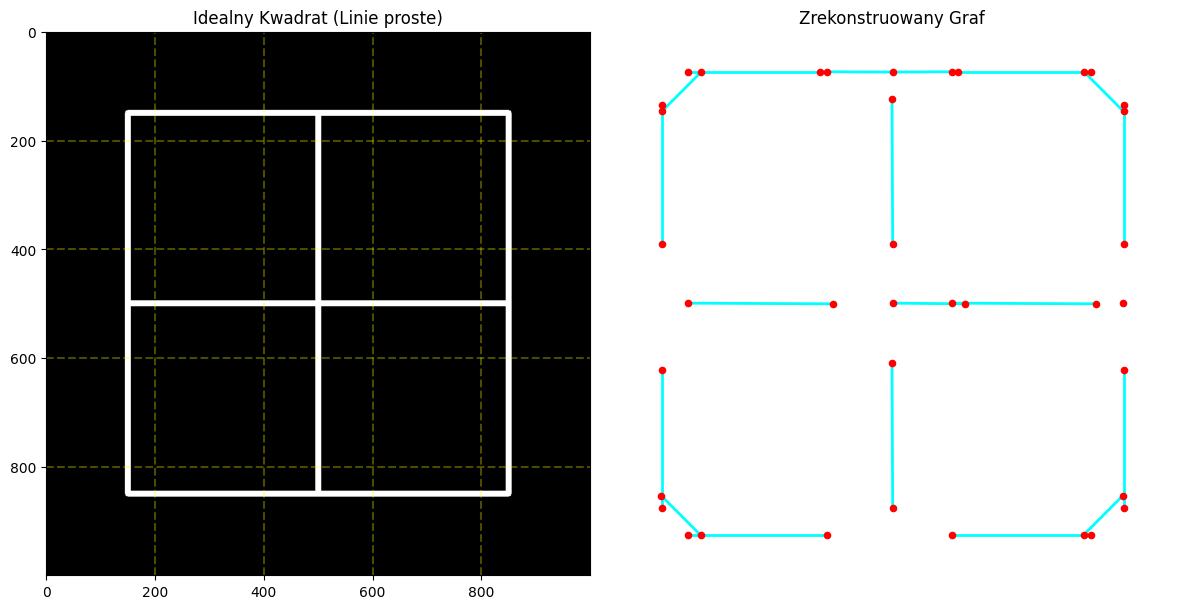

In [7]:
import matplotlib.pyplot as plt
import networkx as nx
import os
import cv2
import numpy as np
import math
from grid_manager import GridManager, GRID_INDICES
from graph_remaker.memory_wise import process_large_grid

# 1. GENEROWANIE SZTUCZNEGO OBRAZU
H, W = 1000, 1000
SEG_SIZE = 200
TEMP_GRID_FILE = "square_test.dat"

print(f"Generowanie obrazu {W}x{H}...")
img = np.zeros((H, W), dtype=np.uint8)

# Rysujemy KWADRAT (linie prostopadłe do osi)
# Współrzędne: (150, 150) do (850, 850)
# Linie będą przecinać granice segmentów (które są co 200px) idealnie prosto.
cv2.rectangle(img, (150, 150), (850, 850), 255, thickness=10)

# Dodajmy Krzyż w środku (żeby przetestować skrzyżowania typu "4-way")
cv2.line(img, (500, 150), (500, 850), 255, thickness=10) # Pion
cv2.line(img, (150, 500), (850, 500), 255, thickness=10) # Poziom

print("Obraz wygenerowany.")

# 2. ZAPIS DO PLIKU
if os.path.exists(os.path.join("grids", TEMP_GRID_FILE)):
    os.remove(os.path.join("grids", TEMP_GRID_FILE))

gm = GridManager(TEMP_GRID_FILE, H, W,
                 upper_left_longitude=0.0, upper_left_latitude=0.0,
                 grid_density=1.0,
                 segment_h=SEG_SIZE, segment_w=SEG_SIZE)

img_binary = (img > 0).astype(np.float32)

rows_n = math.ceil(H / SEG_SIZE)
cols_n = math.ceil(W / SEG_SIZE)

print(f"Dzielenie na {rows_n}x{cols_n} segmentów...")

for r in range(rows_n):
    for c in range(cols_n):
        y_start = r * SEG_SIZE
        x_start = c * SEG_SIZE
        y_end = min(y_start + SEG_SIZE, H)
        x_end = min(x_start + SEG_SIZE, W)

        chunk = img_binary[y_start:y_end, x_start:x_end]
        gm.write_segment(chunk, r, c)

print("Dane zapisane. Uruchamiam memory_wise...")

# 3. URUCHOMIENIE
try:
    # Używamy tej wersji memory_wise, którą masz teraz (z patchem i snappingiem)
    graph = process_large_grid(TEMP_GRID_FILE)

    # 4. WIZUALIZACJA
    print(f"\n--- WYNIK ---")
    print(f"Węzły: {len(graph.nodes)}")
    print(f"Krawędzie: {len(graph.edges)}")

    plt.figure(figsize=(12, 6))

    # Lewa: Obraz
    plt.subplot(1, 2, 1)
    plt.title(f"Idealny Kwadrat (Linie proste)")
    plt.imshow(img, cmap='gray')

    # Siatka cięcia
    for y in range(0, H, SEG_SIZE):
        plt.axhline(y, color='yellow', linestyle='--', alpha=0.3)
    for x in range(0, W, SEG_SIZE):
        plt.axvline(x, color='yellow', linestyle='--', alpha=0.3)

    # Prawa: Graf
    plt.subplot(1, 2, 2)
    plt.title("Zrekonstruowany Graf")

    if len(graph.nodes) > 0:
        pos = {n: (data['x'], data['y']) for n, data in graph.nodes(data=True)}

        nx.draw(graph, pos,
                node_size=20,
                node_color='red',
                edge_color='cyan',
                width=2,
                with_labels=False,
                arrows=False)
        plt.axis('equal')
        plt.gca().invert_yaxis() # Żeby góra była na górze
    else:
        plt.text(0.5, 0.5, "BRAK WYNIKÓW", ha='center', color='red', fontsize=15)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"CRITICAL ERROR: {e}")
    import traceback
    traceback.print_exc()